In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/AAXJ2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,61.439999,61.939999,61.340000,61.759998,53.829903,520200
1,1/3/2013,61.320000,61.660000,61.230000,61.290001,53.420250,416900
2,1/4/2013,61.060001,61.330002,60.950001,61.290001,53.420250,296400
3,1/7/2013,60.880001,60.880001,60.639999,60.810001,53.001884,249900
4,1/8/2013,60.590000,60.599998,60.119999,60.299999,52.557358,219100


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: -5.450016.3, cost: 0.005125, total money: 9994.549984
epoch: 20, total rewards: 1.539959.3, cost: 0.005203, total money: 10001.539959
epoch: 30, total rewards: -63.570007.3, cost: 0.003873, total money: 9936.429993
epoch: 40, total rewards: 6.350006.3, cost: 0.003631, total money: 10006.350006
epoch: 50, total rewards: -44.710003.3, cost: 0.008464, total money: 9028.210003
epoch: 60, total rewards: -128.829983.3, cost: 0.018188, total money: 8052.830021
epoch: 70, total rewards: -196.589943.3, cost: 0.056850, total money: 5955.300056
epoch: 80, total rewards: -291.889954.3, cost: 0.048294, total money: 6129.250038
epoch: 90, total rewards: -167.709927.3, cost: 0.079668, total money: 4732.370052
epoch: 100, total rewards: -181.309917.3, cost: 0.092708, total money: 4151.490055
epoch: 110

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 60.689999, total balance 9939.310001
day 13, sell 1 unit at price 61.110001, investment 0.692045 %, total balance 10000.420002,
day 16: buy 1 unit at price 60.250000, total balance 9940.170002
day 22, sell 1 unit at price 59.950001, investment -0.497924 %, total balance 10000.120003,
day 31: buy 1 unit at price 60.630001, total balance 9939.490002
day 34: buy 1 unit at price 59.790001, total balance 9879.700001
day 40, sell 1 unit at price 60.130001, investment -0.824674 %, total balance 9939.830002,
day 42: buy 1 unit at price 60.160000, total balance 9879.670002
day 44: buy 1 unit at price 60.389999, total balance 9819.280003
day 45: buy 1 unit at price 60.709999, total balance 9758.570004
day 46: buy 1 unit at price 60.389999, total balance 9698.180004
day 47, sell 1 unit at price 59.750000, investment -0.066902 %, total balance 9757.930004,
day 48, sell 1 unit at price 59.180000, investment -1.628989 %, total balance 9817.110004,
day 50: buy 1 unit at pr

day 355: buy 1 unit at price 62.080002, total balance 9454.489986
day 356: buy 1 unit at price 62.480000, total balance 9392.009987
day 360, sell 1 unit at price 62.939999, investment 4.969979 %, total balance 9454.949985,
day 363: buy 1 unit at price 62.639999, total balance 9392.309986
day 369, sell 1 unit at price 62.509998, investment 4.759511 %, total balance 9454.819984,
day 370, sell 1 unit at price 62.320000, investment 4.845224 %, total balance 9517.139984,
day 373: buy 1 unit at price 62.509998, total balance 9454.629986
day 377: buy 1 unit at price 63.830002, total balance 9390.799984
day 378, sell 1 unit at price 64.080002, investment 5.847375 %, total balance 9454.879986,
day 379, sell 1 unit at price 64.080002, investment 3.739682 %, total balance 9518.959988,
day 380: buy 1 unit at price 63.730000, total balance 9455.229988
day 381: buy 1 unit at price 63.860001, total balance 9391.369987
day 382, sell 1 unit at price 63.610001, investment 3.802222 %, total balance 9454.

day 598: buy 1 unit at price 67.879997, total balance 8072.399990
day 599: buy 1 unit at price 67.769997, total balance 8004.629993
day 600, sell 1 unit at price 67.680000, investment 11.078287 %, total balance 8072.309994,
day 602: buy 1 unit at price 67.889999, total balance 8004.419994
day 604, sell 1 unit at price 66.610001, investment 8.875450 %, total balance 8071.029995,
day 609: buy 1 unit at price 65.239998, total balance 8005.789997
day 612, sell 1 unit at price 64.029999, investment 3.709098 %, total balance 8069.819996,
day 616, sell 1 unit at price 63.730000, investment 3.744098 %, total balance 8133.549995,
day 617, sell 1 unit at price 63.459999, investment -0.688580 %, total balance 8197.009994,
day 621: buy 1 unit at price 64.900002, total balance 8132.109993
day 623, sell 1 unit at price 65.150002, investment 3.265179 %, total balance 8197.259994,
day 624, sell 1 unit at price 64.500000, investment 3.166986 %, total balance 8261.759994,
day 625: buy 1 unit at price 63

day 901: buy 1 unit at price 57.669998, total balance 8360.440014
day 907: buy 1 unit at price 58.910000, total balance 8301.530014
day 908, sell 1 unit at price 58.919998, investment 8.468333 %, total balance 8360.450012,
day 909: buy 1 unit at price 59.540001, total balance 8300.910011
day 910: buy 1 unit at price 59.430000, total balance 8241.480011
day 912: buy 1 unit at price 59.700001, total balance 8181.780010
day 913: buy 1 unit at price 59.380001, total balance 8122.400009
day 915: buy 1 unit at price 59.470001, total balance 8062.930008
day 921: buy 1 unit at price 59.040001, total balance 8003.890007
day 922: buy 1 unit at price 59.119999, total balance 7944.770008
day 923, sell 1 unit at price 58.680000, investment 8.165899 %, total balance 8003.450008,
day 925: buy 1 unit at price 59.820000, total balance 7943.630009
day 926, sell 1 unit at price 61.020000, investment 10.744106 %, total balance 8004.650009,
day 927, sell 1 unit at price 61.119999, investment 9.006598 %, to

day 1103: buy 1 unit at price 66.419998, total balance 7270.459991
day 1104, sell 1 unit at price 66.620003, investment 9.500333 %, total balance 7337.079994,
day 1105: buy 1 unit at price 66.290001, total balance 7270.789993
day 1106: buy 1 unit at price 66.480003, total balance 7204.309990
day 1107: buy 1 unit at price 67.099998, total balance 7137.209991
day 1108, sell 1 unit at price 67.220001, investment 10.016371 %, total balance 7204.429993,
day 1110: buy 1 unit at price 66.760002, total balance 7137.669990
day 1111, sell 1 unit at price 67.379997, investment 12.449932 %, total balance 7205.049988,
day 1112, sell 1 unit at price 67.779999, investment 12.535280 %, total balance 7272.829987,
day 1114: buy 1 unit at price 67.839996, total balance 7204.989990
day 1115: buy 1 unit at price 67.769997, total balance 7137.219994
day 1118: buy 1 unit at price 67.370003, total balance 7069.849991
day 1119: buy 1 unit at price 67.820000, total balance 7002.029991
day 1120, sell 1 unit at p

day 1294: buy 1 unit at price 77.739998, total balance 5065.090004
day 1297: buy 1 unit at price 77.720001, total balance 4987.370003
day 1298, sell 1 unit at price 76.739998, investment 17.160302 %, total balance 5064.110001,
day 1299, sell 1 unit at price 76.610001, investment 15.341769 %, total balance 5140.720001,
day 1302: buy 1 unit at price 77.540001, total balance 5063.180000
day 1303, sell 1 unit at price 77.529999, investment 16.955797 %, total balance 5140.709999,
day 1304, sell 1 unit at price 77.830002, investment 17.072801 %, total balance 5218.540001,
day 1305: buy 1 unit at price 79.540001, total balance 5139.000000
day 1306: buy 1 unit at price 79.779999, total balance 5059.220001
day 1307: buy 1 unit at price 79.209999, total balance 4980.010002
day 1308: buy 1 unit at price 79.489998, total balance 4900.520004
day 1309: buy 1 unit at price 79.639999, total balance 4820.880005
day 1312: buy 1 unit at price 79.470001, total balance 4741.410004
day 1313, sell 1 unit at 

day 1480: buy 1 unit at price 66.150002, total balance 4003.219990
day 1481, sell 1 unit at price 66.199997, investment -12.096668 %, total balance 4069.419987,
day 1482, sell 1 unit at price 65.139999, investment -14.244339 %, total balance 4134.559986,
day 1483, sell 1 unit at price 63.910000, investment -15.996322 %, total balance 4198.469986,
day 1484: buy 1 unit at price 65.110001, total balance 4133.359985
day 1485, sell 1 unit at price 64.449997, investment -17.667351 %, total balance 4197.809982,
day 1488, sell 1 unit at price 67.410004, investment -13.973962 %, total balance 4265.219986,
day 1489, sell 1 unit at price 66.650002, investment -14.022182 %, total balance 4331.869987,
day 1490: buy 1 unit at price 66.769997, total balance 4265.099991
day 1491: buy 1 unit at price 68.290001, total balance 4196.809990
day 1492: buy 1 unit at price 66.879997, total balance 4129.929993
day 1494: buy 1 unit at price 64.830002, total balance 4065.099991
day 1497: buy 1 unit at price 65.8

day 1683: buy 1 unit at price 67.500000, total balance 3407.019997
day 1684, sell 1 unit at price 67.970001, investment -6.762689 %, total balance 3474.989998,
day 1685, sell 1 unit at price 68.449997, investment -6.297065 %, total balance 3543.439995,
day 1686: buy 1 unit at price 68.919998, total balance 3474.519997
day 1687: buy 1 unit at price 68.110001, total balance 3406.409996
day 1689, sell 1 unit at price 67.910004, investment -5.087350 %, total balance 3474.320000,
day 1690: buy 1 unit at price 67.550003, total balance 3406.769997
day 1692: buy 1 unit at price 67.599998, total balance 3339.169998
day 1694, sell 1 unit at price 66.910004, investment -6.143915 %, total balance 3406.080002,
day 1696: buy 1 unit at price 65.879997, total balance 3340.200005
day 1702: buy 1 unit at price 66.019997, total balance 3274.180008
day 1703, sell 1 unit at price 65.639999, investment -7.989904 %, total balance 3339.820007,
day 1704: buy 1 unit at price 66.080002, total balance 3273.740005

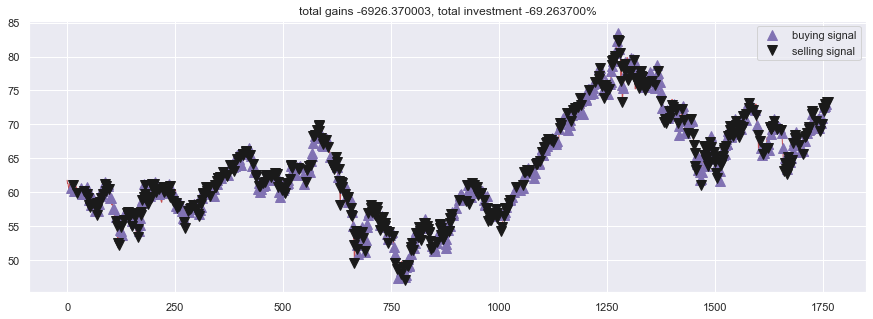

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()